<a href="https://colab.research.google.com/github/jamessutton600613-png/GC/blob/main/Copy_of_Untitled182.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cell 1: Simulation Parameters
import numpy as np

# Define simulation parameters
Lx, Ly = 100, 100  # Domain size
Nx, Ny = 100, 100  # Number of grid points
dx, dy = Lx / Nx, Ly / Ny # Grid spacing
dt = 0.001 # Time step (kept small for stability)
T_sim = 5.0 # Total simulation time for full runs
Nt = int(T_sim / dt) # Number of time steps for full runs

# Define parameters for short test simulations
Nt_test = 500 # Number of time steps for short test runs

report_interval = 500 # Report progress every N steps
checkpoint_interval = 20000 # Save state every N steps
plot_interval = 20000 # Plot results every N steps


# Define species lists
species_list = ['Na', 'Cl', 'Substrate', 'ATP', 'ADP', 'Pi', 'Inhibitor']
enzyme_states_list = ['Free', 'SaltBound', 'SubstrateBound', 'ATPBound', 'ADP_PiBound', 'InhibitorBound']
all_species = species_list + ['Enzyme_' + state for state in enzyme_states_list]

# Define the location of the salt crystal
C_salt_sat = 1.0
salt_crystal_x_start, salt_crystal_x_end = 0, int(Nx * 0.2)
salt_crystal_y_start, salt_crystal_y_end = 0, int(Ny * 0.2)

# Define diffusion coefficients
diffusion_coefficients = {
    'Na': 1.0, 'Cl': 1.0, 'Substrate': 0.5,
    'ATP': 0.5, 'ADP': 0.5, 'Pi': 0.5, 'Inhibitor': 0.5
}
D_Enzyme = 0.1
for state in enzyme_states_list:
    diffusion_coefficients['Enzyme_' + state] = D_Enzyme

# Define charge for each species (in units of elementary charge e) - Doubling enzyme charge
base_enzyme_charge = -10 # Doubled from -5
charges = {
    'Na': 1, 'Cl': -1, 'Substrate': -2,
    'ATP': -4, 'ADP': -3, 'Pi': -2,
    'Inhibitor': -1,
    'Enzyme_Free': base_enzyme_charge,
    'Enzyme_SaltBound': base_enzyme_charge + 1 + (-1), # Assuming charge changes upon binding
    'Enzyme_SubstrateBound': base_enzyme_charge + (-2),
    'Enzyme_ATPBound': base_enzyme_charge + (-4),
    'Enzyme_ADP_PiBound': base_enzyme_charge + (-3) + (-2),
    'Enzyme_InhibitorBound': base_enzyme_charge + (-1)
}
for species in all_species:
    if species not in charges:
        charges[species] = 0

# Define mobility for each species (Einstein relation, assuming kT=1 for simplicity)
mobilities = {species: diffusion_coefficients[species] * charges[species] for species in all_species}

# Permittivity of the medium (placeholder)
epsilon = 1.0

# Define rate constants
rate_constants = {
    'k_on_salt': 0.1, 'k_off_salt': 0.05,
    'k_on_substrate': 0.2, 'k_off_substrate': 0.1,
    'k_on_ATP': 0.3, 'k_off_ATP': 0.15,
    'k_hydrolysis': 0.5, 'k_reverse_hydrolysis': 0.01,
    'k_on_inhibitor': 0.4, 'k_off_inhibitor': 0.2,
    'k_transition_ADP_Pi_Free': 0.2
}

print("Simulation parameters and species properties defined.")

Simulation parameters and species properties defined.


In [ ]:
# Cell 2: Simulation Functions
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import numpy as np # Redundant import but ensuring standalone function definition
import matplotlib.pyplot as plt # Import matplotlib for plotting
import matplotlib.colors as mcolors # Import mcolors for normalization
import os # Import os for directory creation
import time # Import time for performance reporting


# Reaction rates function (same as before, operating on the unified concentrations dictionary)
def reaction_rates_full(concentrations, rates_constants, all_species, enzyme_states_list):
    rates = {species: np.zeros_like(concentrations['Na']) for species in all_species}

    # Extract concentrations
    c_Na = concentrations['Na']
    c_Cl = concentrations['Cl']
    c_Substrate = concentrations['Substrate']
    c_ATP = concentrations['ATP']
    c_ADP = concentrations['ADP']
    c_Pi = concentrations['Pi']
    c_Inhibitor = concentrations['Inhibitor']

    # Enzyme states
    E_Free = concentrations['Enzyme_Free']
    E_Salt = concentrations['Enzyme_SaltBound']
    E_Substrate = concentrations['Enzyme_SubstrateBound']
    E_ATP = concentrations['Enzyme_ATPBound']
    E_ADP_Pi = concentrations['Enzyme_ADP_PiBound']
    E_Inhibitor = concentrations['Enzyme_InhibitorBound']

    # --- Calculate all reaction rates first ---

    # Binding and Unbinding Reactions
    rate_E_Free_to_Salt = rates_constants['k_on_salt'] * E_Free * c_Na
    rate_E_Salt_to_Free = rates_constants['k_off_salt'] * E_Salt

    rate_E_Free_to_Substrate = rates_constants['k_on_substrate'] * E_Free * c_Substrate
    rate_E_Substrate_to_Free = rates_constants['k_off_substrate'] * E_Substrate

    rate_E_Free_to_ATP = rates_constants['k_on_ATP'] * E_Free * c_ATP
    rate_E_ATP_to_Free = rates_constants['k_off_ATP'] * E_ATP

    rate_E_Free_to_Inhibitor = rates_constants['k_on_inhibitor'] * E_Free * c_Inhibitor
    rate_E_Inhibitor_to_Free = rates_constants['k_off_inhibitor'] * E_Inhibitor

    # ATP Hydrolysis and Product Release
    rate_E_ATP_to_ADP_Pi = rates_constants['k_hydrolysis'] * E_ATP
    rate_E_ADP_Pi_to_ATP = rates_constants['k_reverse_hydrolysis'] * E_ADP_Pi # Reverse reaction is rare

    rate_E_ADP_Pi_to_Free = rates_constants['k_transition_ADP_Pi_Free'] * E_ADP_Pi


    # --- Update species rates based on calculated reaction rates ---

    # Enzyme state changes
    rates['Enzyme_Free'] += (rate_E_Salt_to_Free - rate_E_Free_to_Salt) + \
                           (rate_E_Substrate_to_Free - rate_E_Free_to_Substrate) + \
                           (rate_E_ATP_to_Free - rate_E_Free_to_ATP) + \
                           (rate_E_Inhibitor_to_Free - rate_E_Free_to_Inhibitor) + \
                           rate_E_ADP_Pi_to_Free

    rates['Enzyme_SaltBound'] += rate_E_Free_to_Salt - rate_E_Salt_to_Free

    rates['Enzyme_SubstrateBound'] += rate_E_Free_to_Substrate - rate_E_Substrate_to_Free

    rates['Enzyme_ATPBound'] += (rate_E_Free_to_ATP - rate_E_ATP_to_Free) + \
                               (rate_E_ADP_Pi_to_ATP - rate_E_ATP_to_ADP_Pi) # From Free/To Free, and from ADP_Pi/To ADP_Pi

    rates['Enzyme_ADP_PiBound'] += (rate_E_ATP_to_ADP_Pi - rate_E_ADP_Pi_to_ATP) - \
                                  rate_E_ADP_Pi_to_Free # From ATP/To ATP, and leaving for Free

    rates['Enzyme_InhibitorBound'] += rate_E_Free_to_Inhibitor - rate_E_Inhibitor_to_Free


    # Ligand concentration changes
    rates['Na'] += -rate_E_Free_to_Salt + rate_E_Salt_to_Free # Consumption/production upon binding
    rates['Cl'] += -rate_E_Free_to_Salt + rate_E_Salt_to_Free # Assuming coupled binding

    rates['Substrate'] += -rate_E_Free_to_Substrate + rate_E_Substrate_to_Free

    rates['ATP'] += -rate_E_Free_to_ATP + rate_E_ATP_to_Free - rate_E_ATP_to_ADP_Pi + rate_E_ADP_Pi_to_ATP
    rates['ADP'] += rate_E_ATP_to_ADP_Pi - rate_E_ADP_Pi_to_ATP + rate_E_ADP_Pi_to_Free
    rates['Pi'] += rate_E_ATP_to_ADP_Pi - rate_E_ADP_Pi_to_ATP + rate_E_ADP_Pi_to_Free

    rates['Inhibitor'] += -rate_E_Free_to_Inhibitor + rate_E_Inhibitor_to_Free


    return rates

# Implement a finite difference Poisson solver
def solve_poisson_fd(charge_density, epsilon, dx, dy, Nx, Ny):
    N_total = Ny * Nx

    # Construct the sparse matrix for the 2D Laplacian operator
    A = lil_matrix((N_total, N_total))
    b = (charge_density / epsilon).reshape(N_total)

    for i in range(Ny):
        for j in range(Nx):
            row_idx = i * Nx + j

            # Apply boundary conditions: Assume fixed potential phi = 0 at boundaries for simplicity.
            if 0 < i < Ny - 1 and 0 < j < Nx - 1:
                A[row_idx, row_idx] = 2.0 / dx**2 + 2.0 / dy**2
                A[row_idx, row_idx + 1] = -1.0 / dx**2 # Right neighbor
                A[row_idx, row_idx - 1] = -1.0 / dx**2 # Left neighbor
                A[row_idx, row_idx + Nx] = -1.0 / dy**2 # Bottom neighbor
                A[row_idx, row_idx - Nx] = -1.0 / dy**2 # Top neighbor
            else:
                # Boundary point: phi(i, j) = 0
                A[row_idx, row_idx] = 1.0
                b[row_idx] = 0.0

    # Solve the linear system A * phi_vector = b_vector
    A = A.tocsr()
    phi_vector = spsolve(A, b)

    return phi_vector.reshape((Ny, Nx))

# Function to calculate drift terms based on electrostatic potential
def calculate_drift_from_phi(concentrations, mobilities, phi, dx, dy, all_species):
    drift_terms = {}
    grad_phi_y, grad_phi_x = np.gradient(phi, dy, dx)

    for species in all_species:
        c = concentrations[species]
        mu = mobilities[species]

        J_drift_x = -c * mu * grad_phi_x
        J_drift_y = -c * mu * grad_phi_y

        div_J_drift = np.gradient(J_drift_x, dx, axis=1) + np.gradient(J_drift_y, dy, axis=0)
        drift_terms[species] = div_J_drift

    return drift_terms

# Function to calculate salt dissolution rate from flux at the crystal surface
def calculate_salt_dissolution_rate(concentrations, diffusion_coefficients, mobilities, phi, dx, dy, salt_crystal_x_end, salt_crystal_y_end, C_salt_sat, Nx, Ny):
    flux_Na = 0
    flux_Cl = 0

    # Flux across the right boundary of the crystal (x = salt_crystal_x_end)
    if salt_crystal_x_end < Nx:
        grad_c_Na_x_boundary = (concentrations['Na'][:, salt_crystal_x_end] - concentrations['Na'][:, salt_crystal_x_end - 1]) / dx
        grad_c_Cl_x_boundary = (concentrations['Cl'][:, salt_crystal_x_end] - concentrations['Cl'][:, salt_crystal_x_end - 1]) / dx
        grad_phi_x_boundary = (phi[:, salt_crystal_x_end] - phi[:, salt_crystal_x_end - 1]) / dx

        c_Na_avg = (C_salt_sat + concentrations['Na'][:, salt_crystal_x_end]) / 2.0
        c_Cl_avg = (C_salt_sat + concentrations['Cl'][:, salt_crystal_x_end]) / 2.0
        phi_avg = (phi[:, salt_crystal_x_end - 1] + phi[:, salt_crystal_x_end]) / 2.0

        J_Na_x = -diffusion_coefficients['Na'] * grad_c_Na_x_boundary - mobilities['Na'] * c_Na_avg * grad_phi_x_boundary
        J_Cl_x = -diffusion_coefficients['Cl'] * grad_c_Cl_x_boundary - mobilities['Cl'] * c_Cl_avg * grad_phi_x_boundary

        flux_Na_right = np.sum(J_Na_x[salt_crystal_y_start:salt_crystal_y_end]) * dy
        flux_Cl_right = np.sum(J_Cl_x[salt_crystal_y_start:salt_crystal_y_end]) * dy

        flux_Na += flux_Na_right
        flux_Cl += flux_Cl_right

    # Flux across the top boundary of the crystal (y = salt_crystal_y_end)
    if salt_crystal_y_end < Ny:
        grad_c_Na_y_boundary = (concentrations['Na'][salt_crystal_y_end, :] - concentrations['Na'][salt_crystal_y_end - 1, :]) / dy
        grad_c_Cl_y_boundary = (concentrations['Cl'][salt_crystal_y_end, :] - concentrations['Cl'][salt_crystal_y_end - 1, :]) / dy
        grad_phi_y_boundary = (phi[salt_crystal_y_end, :] - phi[salt_crystal_y_end - 1, :]) / dy # Corrected tuple slicing


        c_Na_avg = (C_salt_sat + concentrations['Na'][salt_crystal_y_end, :]) / 2.0
        c_Cl_avg = (C_salt_sat + concentrations['Cl'][salt_crystal_y_end, :]) / 2.0
        phi_avg = (phi[salt_crystal_y_end - 1, :] + phi[salt_crystal_y_end, :]) / 2.0


        J_Na_y = -diffusion_coefficients['Na'] * grad_c_Na_y_boundary - mobilities['Na'] * c_Na_avg * grad_phi_y_boundary
        J_Cl_y = -diffusion_coefficients['Cl'] * grad_c_Cl_y_boundary - mobilities['Cl'] * c_Cl_avg * grad_phi_y_boundary

        flux_Na_top = np.sum(J_Na_y[salt_crystal_x_start:salt_crystal_x_end]) * dx
        flux_Cl_top = np.sum(J_Cl_y[salt_crystal_x_start:salt_crystal_x_end]) * dx

        flux_Na += flux_Na_top
        flux_Cl += flux_Cl_top

    dissolution_rate = (flux_Na + flux_Cl) / 2.0

    return dissolution_rate

# Function to save the simulation state
def save_simulation_state(step, concentrations, cumulative_dissolved_salt, dissolution_rate_history, total_enzyme_history, output_dir="simulation_checkpoints", filename=None):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # If a specific filename is provided, use it. Otherwise, generate one based on step.
    if filename:
        # If filename is a base name, join with output_dir. If it's already a path, use it.
        if not os.path.isabs(filename):
             filepath = os.path.join(output_dir, filename)
        else:
             filepath = filename # Use the absolute path if provided
    else:
        filepath = os.path.join(output_dir, f"state_step_{step}.npz")


    # Convert concentrations dictionary values to NumPy arrays if they are not already
    concentrations_np = {key: np.array(value) for key, value in concentrations.items()}

    save_data = {
        'step': step,
        'cumulative_dissolved_salt': cumulative_dissolved_salt,
        'dissolution_rate_history': np.array(dissolution_rate_history), # Save as numpy array
        'total_enzyme_history': np.array(total_enzyme_history), # Assume it's always a list/array if passed
        'concentrations': concentrations_np # Save the dictionary of concentration arrays
    }
    np.savez(filepath, **save_data)
    print(f"Simulation state saved at step {step} to {filepath}")

# Function to load the simulation state
def load_simulation_state(filename):
    if not os.path.exists(filename):
        print(f"Checkpoint file not found at {filename}")
        return None

    try:
        loaded_data = np.load(filename, allow_pickle=True) # allow_pickle=True needed for dictionaries

        # Reconstruct the concentrations dictionary
        loaded_concentrations = loaded_data['concentrations'].item() # .item() to get the dictionary

        # Load total_enzyme_history - assume it's always present as an array if the sim included enzyme
        total_enzyme_hist = loaded_data['total_enzyme_history'].tolist() if 'total_enzyme_history' in loaded_data and loaded_data['total_enzyme_history'].size > 0 else []


        print(f"Simulation state loaded from {filename}")
        return (loaded_data['step'].item(),
                loaded_concentrations,
                loaded_data['cumulative_dissolved_salt'].item(),
                loaded_data['dissolution_rate_history'].tolist(), # Convert back to list
                total_enzyme_hist) # Return loaded history


    except Exception as e:
        print(f"Error loading checkpoint file {filename}: {e}")
        return None

# Helper function to create initial concentration dictionary with zeros for all species
def create_initial_concentrations(all_species, Ny, Nx):
    return {species: np.zeros((Ny, Nx)) for species in all_species}


# Function to run a simulation condition (updated for checkpointing, plotting, and location args)
def run_simulation_condition_with_checkpointing(sim_name, initial_concentrations, initial_enzyme_conc=0,
                                                 enzyme_location=None,
                                                 atp_location=None, # Added specific ATP location
                                                 substrate_location=None, # Added specific Substrate location
                                                 inhibitor_location=None,
                                                 Nt=1000, dt=0.001, report_interval=500,
                                                 checkpoint_interval=1000, plot_interval=1000,
                                                 resume_all_simulations=False,
                                                 # Pass global parameters explicitly
                                                 all_species=None, enzyme_states_list=None, charges=None,
                                                 diffusion_coefficients=None, mobilities=None, epsilon=None,
                                                 rate_constants=None, Nx=None, Ny=None, dx=None, dy=None,
                                                 salt_crystal_x_start=None, salt_crystal_x_end=None,
                                                 salt_crystal_y_start=None, salt_crystal_y_end=None,
                                                 C_salt_sat=None):

    print(f"\n--- Running simulation condition: {sim_name} ---")

    output_dir = f"simulation_results/{sim_name}"
    checkpoint_dir = f"simulation_checkpoints/{sim_name}"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)


    start_step = 0
    concentrations = initial_concentrations
    dissolution_rate_over_time = []
    cumulative_dissolved_salt = 0
    total_enzyme_over_time = [] # Track total enzyme for this simulation

    checkpoint_filename = os.path.join(checkpoint_dir, f"{sim_name}_latest_checkpoint.npz")

    if resume_all_simulations and os.path.exists(checkpoint_filename):
        print(f"Attempting to resume from checkpoint: {checkpoint_filename}")
        loaded_state = load_simulation_state(checkpoint_filename)
        if loaded_state:
            start_step, concentrations, cumulative_dissolved_salt, dissolution_rate_over_time, total_enzyme_over_time = loaded_state
            print(f"Resuming simulation '{sim_name}' from step {start_step}...")
        else:
            print(f"Failed to load checkpoint for '{sim_name}'. Starting from scratch.")
            # If loading failed, proceed with fresh initialization below
            start_step = 0
            concentrations = create_initial_concentrations(all_species, Ny, Nx) # Re-initialize


    # If starting from scratch or failed to resume, initialize concentrations based on location arguments
    if start_step == 0:
        print("Initializing concentrations...")
        # Initialize enzyme if present and enzyme_location is provided, otherwise use default
        if initial_enzyme_conc > 0:
             if enzyme_location:
                 enzyme_init_x_start, enzyme_init_x_end = enzyme_location['x_start'], enzyme_location['x_end']
                 enzyme_init_y_start, enzyme_init_y_end = enzyme_location['y_start'], enzyme_location['y_end']
             else: # Default location if none provided
                 enzyme_init_x_start, enzyme_init_x_end = int(Nx * 0.3), int(Nx * 0.4)
                 enzyme_init_y_start, enzyme_init_y_end = int(Ny * 0.3), int(Ny * 0.4)

             concentrations['Enzyme_Free'][enzyme_init_y_start:enzyme_init_y_end, enzyme_init_x_start:enzyme_init_x_end] = initial_enzyme_conc
             # Ensure other enzyme states are zero initially
             for state in enzyme_states_list:
                 if state != 'Free':
                      concentrations[f'Enzyme_{state}'].fill(0)

        # Handle "Just ATP" initialization - Only initialize ATP
        if atp_location and 'Just_ATP' in sim_name:
             atp_init_x_start, atp_init_x_end = atp_location['x_start'], atp_location['x_end']
             atp_init_y_start, atp_init_y_end = atp_location['y_start'], atp_location['y_end']
             concentrations['ATP'][atp_init_y_start:atp_init_y_end, atp_init_x_start:atp_init_x_end] = 0.5 # Assuming concentration 0.5
             # Ensure substrate, ADP, Pi, Inhibitor are zero in Just ATP
             if 'Substrate' in concentrations: concentrations['Substrate'].fill(0)
             if 'ADP' in concentrations: concentrations['ADP'].fill(0)
             if 'Pi' in concentrations: concentrations['Pi'].fill(0)
             if 'Inhibitor' in concentrations: concentrations['Inhibitor'].fill(0)


        # Handle "Just Substrate" initialization - Only initialize Substrate
        elif substrate_location and 'Just_Substrate' in sim_name:
             sub_init_x_start, sub_init_x_end = substrate_location['x_start'], substrate_location['x_end']
             sub_init_y_start, sub_init_y_end = substrate_location['y_start'], substrate_location['y_end']
             concentrations['Substrate'][sub_init_y_start:sub_init_y_end, sub_init_x_start:sub_init_x_end] = 0.5 # Assuming concentration 0.5
             # Ensure initial ATP, ADP, Pi, Inhibitor are zero in Just Substrate
             if 'ATP' in concentrations: concentrations['ATP'].fill(0)
             if 'ADP' in concentrations: concentrations['ADP'].fill(0)
             if 'Pi' in concentrations: concentrations['Pi'].fill(0)
             if 'Inhibitor' in concentrations: concentrations['Inhibitor'].fill(0)


        # Handle combined Enzyme + Substrate + ATP and Enzyme + Substrate + ATP + Inhibitor
        # Initialize Substrate and ATP if substrate_location or atp_location is provided AND sim name matches
        elif ('Enzyme_Substrate_ATP' in sim_name): # Includes Inhibitor case
            substrate_ATP_init_concentration = 0.5 # Assuming this value
            if substrate_location:
                 sub_x_start, sub_x_end = substrate_location['x_start'], substrate_location['x_end']
                 sub_y_start, sub_y_end = substrate_location['y_start'], substrate_location['y_end']
                 if 'Substrate' in concentrations:
                    concentrations['Substrate'][sub_y_start:sub_y_end, sub_x_start:sub_x_end] = substrate_ATP_init_concentration

            if atp_location:
                 atp_x_start, atp_x_end = atp_location['x_start'], atp_location['x_end']
                 atp_y_start, atp_y_end = atp_location['y_start'], atp_location['y_end']
                 if 'ATP' in concentrations:
                    concentrations['ATP'][atp_y_start:atp_y_end, atp_x_start:atp_x_end] = substrate_ATP_init_concentration

            # Ensure initial ADP/Pi are zero in these combined cases
            if 'ADP' in concentrations: concentrations['ADP'].fill(0)
            if 'Pi' in concentrations: concentrations['Pi'].fill(0)
            # Ensure inhibitor is zero if it's not the inhibitor case
            if 'Inhibitor' in concentrations and 'Inhibitor' not in sim_name:
                 concentrations['Inhibitor'].fill(0)


        # Initialize inhibitor if present and inhibitor_location is provided AND sim name matches
        if inhibitor_location and 'Inhibitor' in sim_name:
            inhibitor_init_concentration = 0.5 # Assuming this value
            inh_x_start, inh_x_end = inhibitor_location['x_start'], inhibitor_location['x_end']
            inh_y_start, inh_y_end = inhibitor_location['y_start'], inhibitor_location['y_end']
            if 'Inhibitor' in concentrations:
                concentrations['Inhibitor'][inh_y_start:inh_y_end, inh_x_start:inh_y_end] = inhibitor_init_concentration
            # Ensure Substrate, ATP, ADP, Pi are zero if it's just Inhibitor (though we don't have a 'Just Inhibitor' sim)
            # If it's Enzyme+Sub+ATP+Inhibitor, Substrate/ATP are initialized above, ADP/Pi are zeroed.


        # Set boundary conditions for the salt crystal: fixed concentration (applied at start and in loop)
        concentrations['Na'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat
        concentrations['Cl'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat

        # Ensure other species not explicitly initialized are zero
        for species in all_species:
             if species not in ['Na', 'Cl', 'Enzyme_Free', 'Substrate', 'ATP', 'Inhibitor'] + [f'Enzyme_{state}' for state in enzyme_states_list if state != 'Free']:
                  concentrations[species].fill(0)


    print(f"Running simulation '{sim_name}' from step {start_step} to {Nt}...")

    # Initialize timer for performance reporting
    start_time = time.time()
    last_report_step = start_step
    last_report_time = time.time()


    # Simulation loop
    for t_step in range(start_step, Nt):
        # Solve Poisson equation for electrostatic potential
        charge_density = sum(concentrations.get(species, np.zeros_like(concentrations['Na'])) * charges.get(species, 0) for species in all_species)
        phi = solve_poisson_fd(charge_density, epsilon, dx, dy, Nx, Ny)

        # Calculate drift terms based on electrostatic potential
        div_drift_terms = calculate_drift_from_phi(concentrations, mobilities, phi, dx, dy, all_species)

        # Calculate reaction rates (enzyme kinetics included if enzyme is present)
        # Reaction rates only apply if enzyme is in a relevant state AND ligands are present.
        # The reaction_rates_full function already handles this by checking concentrations.
        rates = reaction_rates_full(concentrations, rate_constants, all_species, enzyme_states_list)


        # Calculate diffusion terms for all species
        diffusion_terms = {}
        for species in all_species:
            grad_c_y, grad_c_x = np.gradient(concentrations[species], dy, dx)
            laplacian_c = np.gradient(grad_c_y, dy, axis=0) + np.gradient(grad_c_x, dx, axis=1)
            diffusion_terms[species] = diffusion_coefficients[species] * laplacian_c

        # Update concentrations using forward Euler
        # dc/dt = Diffusion + Reaction - Divergence(Drift)
        for species in all_species:
            dcdt = diffusion_terms[species] + rates[species] - div_drift_terms[species]
            concentrations[species] += dcdt * dt

        # Apply boundary conditions for the salt crystal (fixed concentration for Na+ and Cl-)
        concentrations['Na'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat
        concentrations['Cl'][salt_crystal_y_start:salt_crystal_y_end, salt_crystal_x_start:salt_crystal_x_end] = C_salt_sat

        # Apply boundary conditions for other walls (no flux - implicitly handled)

        # Ensure concentrations remain non-negative
        for species in all_species:
             concentrations[species] = np.maximum(concentrations[species], 0)

        # Calculate and store salt dissolution rate
        current_dissolution_rate = calculate_salt_dissolution_rate(
            concentrations, diffusion_coefficients, mobilities, phi, dx, dy,
            salt_crystal_x_end, salt_crystal_y_end, C_salt_sat, Nx, Ny
        )
        # Append only if not resuming from this point - history is loaded
        # The history lists are appended to regardless of resuming or not,
        # as the range(start_step, Nt) loop ensures we only process new steps.
        # The loaded history is already in the lists when resuming.
        dissolution_rate_over_time.append(current_dissolution_rate)
        cumulative_dissolved_salt += current_dissolution_rate * dt


        # Track total enzyme concentration if enzyme is present (or if we want to plot zero)
        # We will always calculate and track total enzyme, even if initial_enzyme_conc is 0
        total_enzyme = sum(concentrations.get(f'Enzyme_{state}', np.zeros_like(concentrations['Na'])).sum() for state in enzyme_states_list)
        total_enzyme_over_time.append(total_enzyme)


        # Periodically display simulation progress
        if (t_step + 1) % report_interval == 0:
            current_time = time.time()
            elapsed_time = current_time - last_report_time
            steps_processed = (t_step + 1) - last_report_step
            steps_per_second = steps_processed / elapsed_time if elapsed_time > 0 else 0

            progress_msg = f"Simulation '{sim_name}': Time step {t_step+1}/{Nt} completed."
            progress_msg += f" Steps per second: {steps_per_second:.2f}"
            # Always include total enzyme in report message
            current_total_enzyme = sum(concentrations.get(f'Enzyme_{state}', np.zeros_like(concentrations['Na'])).sum() for state in enzyme_states_list)
            progress_msg += f" Total enzyme: {current_total_enzyme:.4f}"
            print(progress_msg)

            # Update for next performance report
            last_report_step = t_step + 1
            last_report_time = current_time

        # Save checkpoint (tied to checkpoint_interval)
        if (t_step + 1) % checkpoint_interval == 0 and t_step + 1 < Nt: # Don't save checkpoint at the very end, final state is saved
            save_simulation_state(t_step + 1, concentrations, cumulative_dissolved_salt, dissolution_rate_over_time, total_enzyme_over_time, output_dir=checkpoint_dir, filename=f"{sim_name}_latest_checkpoint.npz")


        # Periodically plot results (tied to plot_interval)
        if (t_step + 1) % plot_interval == 0:
             print(f"Plotting intermediate results at step {t_step+1} for simulation '{sim_name}'")
             # Always pass total_enzyme_over_time, even if it's all zeros
             plot_simulation_results(sim_name, dissolution_rate_over_time, total_enzyme_over_time, concentrations, t_step + 1, Nx, Ny, Lx, Ly, dt, all_species, enzyme_states_list) # Pass plotting params

    print(f"Simulation '{sim_name}' finished.")

    # Save final state
    save_simulation_state(Nt, concentrations, cumulative_dissolved_salt, dissolution_rate_over_time, total_enzyme_over_time, output_dir=checkpoint_dir, filename=f"{sim_name}_final_state.npz")


# Redefine plot_simulation_results to use continuous colormaps and DISPLAY plots
def plot_simulation_results(sim_name, dissolution_rate_history, total_enzyme_history, final_concentrations, current_step,
                            Nx, Ny, Lx, Ly, dt, all_species, enzyme_states_list):

    time_steps = np.arange(len(dissolution_rate_history)) * dt

    # Plot Salt Dissolution Rate over Time
    if dissolution_rate_history and len(dissolution_rate_history) > 0:
        plt.figure(figsize=(10, 6))
        plt.plot(time_steps, dissolution_rate_history, label=sim_name)
        plt.xlabel('Time')
        plt.ylabel('Salt Dissolution Rate')
        plt.title(f'Salt Dissolution Rate Over Time: {sim_name} (Step {current_step})')
        plt.legend()
        plt.grid(True)
        plt.show() # Display plot
        plt.close() # Close the figure

    # Plot Cumulative Dissolved Salt over Time
    if dissolution_rate_history and len(dissolution_rate_history) > 0:
        cumulative_dissolved_salt_over_time = np.cumsum(dissolution_rate_history) * dt
        plt.figure(figsize=(10, 6))
        plt.plot(time_steps, cumulative_dissolved_salt_over_time, label=sim_name)
        plt.xlabel('Time')
        plt.ylabel('Cumulative Dissolved Salt')
        plt.title(f'Cumulative Dissolved Salt Over Time: {sim_name} (Step {current_step})')
        plt.legend()
        plt.grid(True)
        plt.show() # Display plot
        plt.close() # Close the figure

    # Plot Total Enzyme Concentration over Time (always plot, even if zero)
    # The history will be an empty list or all zeros if no enzyme was initialized
    plt.figure(figsize=(10, 6))
    plt.plot(time_steps, total_enzyme_history, label=sim_name)
    plt.xlabel('Time')
    plt.ylabel('Total Enzyme Concentration (Sum over states and grid)')
    plt.title(f'Total Enzyme Concentration Over Time: {sim_name} (Step {current_step})')
    plt.legend()
    plt.grid(True)
    plt.show() # Display plot
    plt.close() # Close the figure


    # Plot spatial distributions (or current distributions at checkpoint)
    print(f"Generating spatial distributions for '{sim_name}' at step {current_step}...")

    # Calculate total enzyme concentration
    total_enzyme_concentration = np.sum([final_concentrations.get(f'Enzyme_{state}', np.zeros((Ny, Nx))) for state in enzyme_states_list], axis=0)


    # Define a list of species to plot spatial distributions for and their preferred continuous colormaps
    species_to_plot_spatial = {
        'Na': 'hot',
        'Cl': 'hot',
        'ATP': 'viridis',
        'Substrate': 'viridis',
        'Inhibitor': 'plasma'
    }

    # Using current state min/max for color scaling within this plot call
    current_state_min_max = {}
    for species in species_to_plot_spatial:
        if species in final_concentrations and final_concentrations[species].size > 0:
            c_min, c_max = final_concentrations[species].min(), final_concentrations[species].max()
            if c_min == c_max: # Avoid division by zero if concentration is uniform
                c_max += 1e-9
            current_state_min_max[species] = (c_min, c_max)
        else:
             current_state_min_max[species] = (0, 1e-9) # Default if species not present or all zero


    # Min/max for Total Enzyme (always calculate min/max even if all zeros)
    if total_enzyme_concentration.size > 0:
         e_min, e_max = total_enzyme_concentration.min(), total_enzyme_concentration.max()
         if e_min == e_max:
             e_max += 1e-9
         current_state_min_max['Total_Enzyme'] = (e_min, e_max)
    else:
        current_state_min_max['Total_Enzyme'] = (0, 1e-9)


    # Determine which species are actually present in this simulation's final concentrations
    # and are in our list of species to plot
    present_spatial_species = [species for species in species_to_plot_spatial if species in final_concentrations]
    # Always plot total enzyme spatial distribution
    plot_total_enzyme_spatial = True


    num_spatial_plots = len(present_spatial_species) + (1 if plot_total_enzyme_spatial else 0)

    # Skip plotting spatial distributions if there are no species to plot
    if num_spatial_plots == 0:
         print(f"No relevant species concentrations found for generating spatial distributions for '{sim_name}'. Skipping spatial plots.")
         return


    fig, axes = plt.subplots(1, num_spatial_plots, figsize=(num_spatial_plots * 6, 6))

    # Ensure axes is an array even if there's only one subplot
    if num_spatial_plots == 1:
        axes = [axes]

    plot_idx = 0

    # Plot Total Enzyme Concentration (spatial distribution - always plot)
    vmin, vmax = current_state_min_max['Total_Enzyme']
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap_enzyme = 'viridis'
    im = axes[plot_idx].imshow(total_enzyme_concentration, extent=[0, Lx, 0, Ly], origin='lower', cmap=cmap_enzyme, norm=norm)
    fig.colorbar(im, ax=axes[plot_idx], label='Total Enzyme Concentration')
    axes[plot_idx].set_title(f'{sim_name}\nTotal Enzyme Distribution')
    axes[plot_idx].set_xlabel('x')
    axes[plot_idx].set_ylabel('y')
    axes[plot_idx].set_aspect('equal', adjustable='box')
    plot_idx += 1


    # Plot spatial distribution for each selected species
    for species in present_spatial_species:
        vmin, vmax = current_state_min_max[species]
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        cmap = species_to_plot_spatial[species] # Get the colormap name
        im = axes[plot_idx].imshow(final_concentrations[species], extent=[0, Lx, 0, Ly], origin='lower', cmap=cmap, norm=norm)
        fig.colorbar(im, ax=axes[plot_idx], label='Concentration')

        axes[plot_idx].set_title(f'{sim_name}\n{species} Concentration Distribution')
        axes[plot_idx].set_xlabel('x')
        axes[plot_idx].set_ylabel('y')
        axes[plot_idx].set_aspect('equal', adjustable='box')
        plot_idx += 1


    plt.tight_layout()
    plt.show() # Display plot
    plt.close() # Close the figure

print("Simulation functions (including plotting) defined.")

Simulation functions (including plotting) defined.


In [ ]:
# Cell 3: Initial Locations
# Define initial locations based on user request
enzyme_initial_location = {
    'x_start': int(Nx * 0.3), 'x_end': int(Nx * 0.4), # Keep enzyme in the same x-location range (30-40)
    'y_start': int(Ny * 0.7), 'y_end': int(Ny * 0.8) # New y-location range for enzyme (70-80)
}

atp_initial_location = {
    'x_start': int(Nx * 0.7), 'x_end': int(Nx * 0.8), # Keep ATP in the same x-location range (70-80)
    'y_start': int(Ny * 0.1), 'y_end': int(Ny * 0.2) # New y-location range for ATP (10-20)
}

inhibitor_initial_location = {
    'x_start': int(Nx * 0.5), 'x_end': int(Nx * 0.6), # New x-location range for inhibitor (50-60)
    'y_start': int(Ny * 0.1), 'y_end': int(Ny * 0.2) # Keep inhibitor in the same y-location range (10-20)
}

# Substrate initial location (centered around (75, 75), 10x10 region)
substrate_initial_location = {
    'x_start': 70, # Center x=75, range 70 to 79 (10 points)
    'x_end': 80,
    'y_start': 70, # Center y=75, range 70 to 79 (10 points)
    'y_end': 80
}

# Define initial enzyme concentration
enzyme_initial_concentration = 0.1

print("Initial locations and enzyme concentration defined.")

Initial locations and enzyme concentration defined.



Running short test simulations (500 steps) with updated locations and plotting...

--- Running simulation condition: Control_Test_NewLocations_DoubleEnzymeCharge ---
Initializing concentrations...
Running simulation 'Control_Test_NewLocations_DoubleEnzymeCharge' from step 0 to 500...
Simulation 'Control_Test_NewLocations_DoubleEnzymeCharge': Time step 100/500 completed. Steps per second: 9.37 Total enzyme: 0.0000
Simulation 'Control_Test_NewLocations_DoubleEnzymeCharge': Time step 200/500 completed. Steps per second: 9.01 Total enzyme: 0.0000
Simulation 'Control_Test_NewLocations_DoubleEnzymeCharge': Time step 300/500 completed. Steps per second: 9.00 Total enzyme: 0.0000
Simulation 'Control_Test_NewLocations_DoubleEnzymeCharge': Time step 400/500 completed. Steps per second: 9.00 Total enzyme: 0.0000
Simulation 'Control_Test_NewLocations_DoubleEnzymeCharge': Time step 500/500 completed. Steps per second: 8.98 Total enzyme: 0.0000
Plotting intermediate results at step 500 for simulati

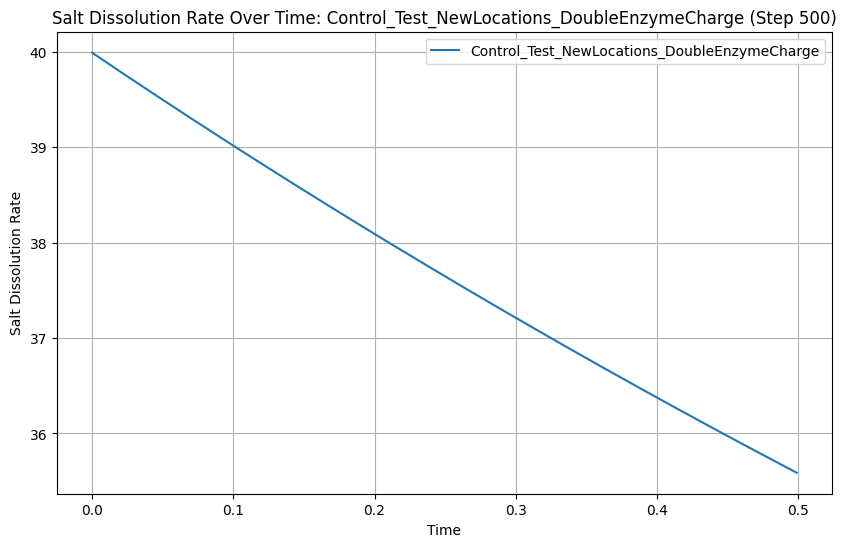

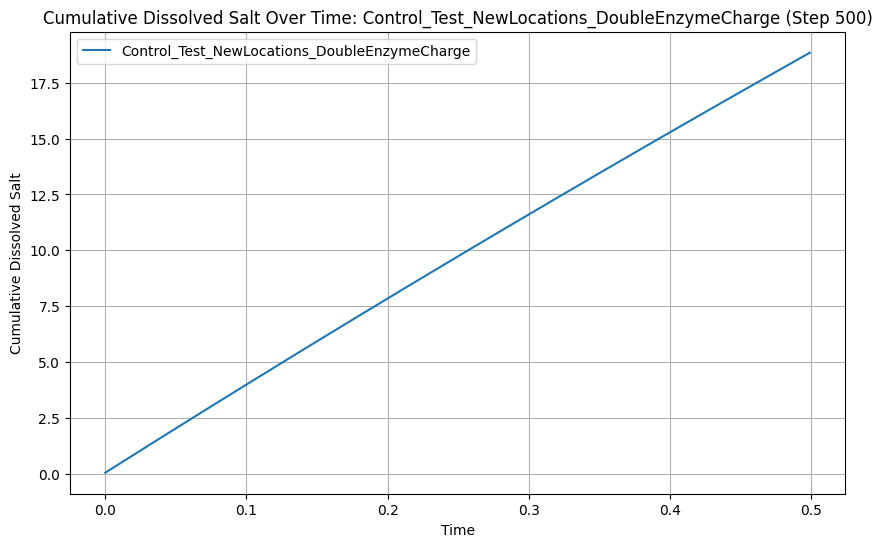

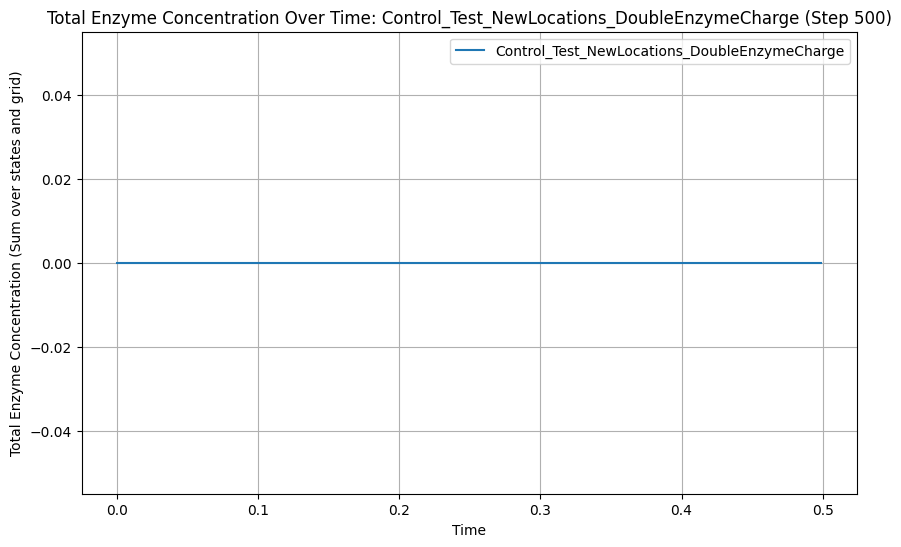

Generating spatial distributions for 'Control_Test_NewLocations_DoubleEnzymeCharge' at step 500...


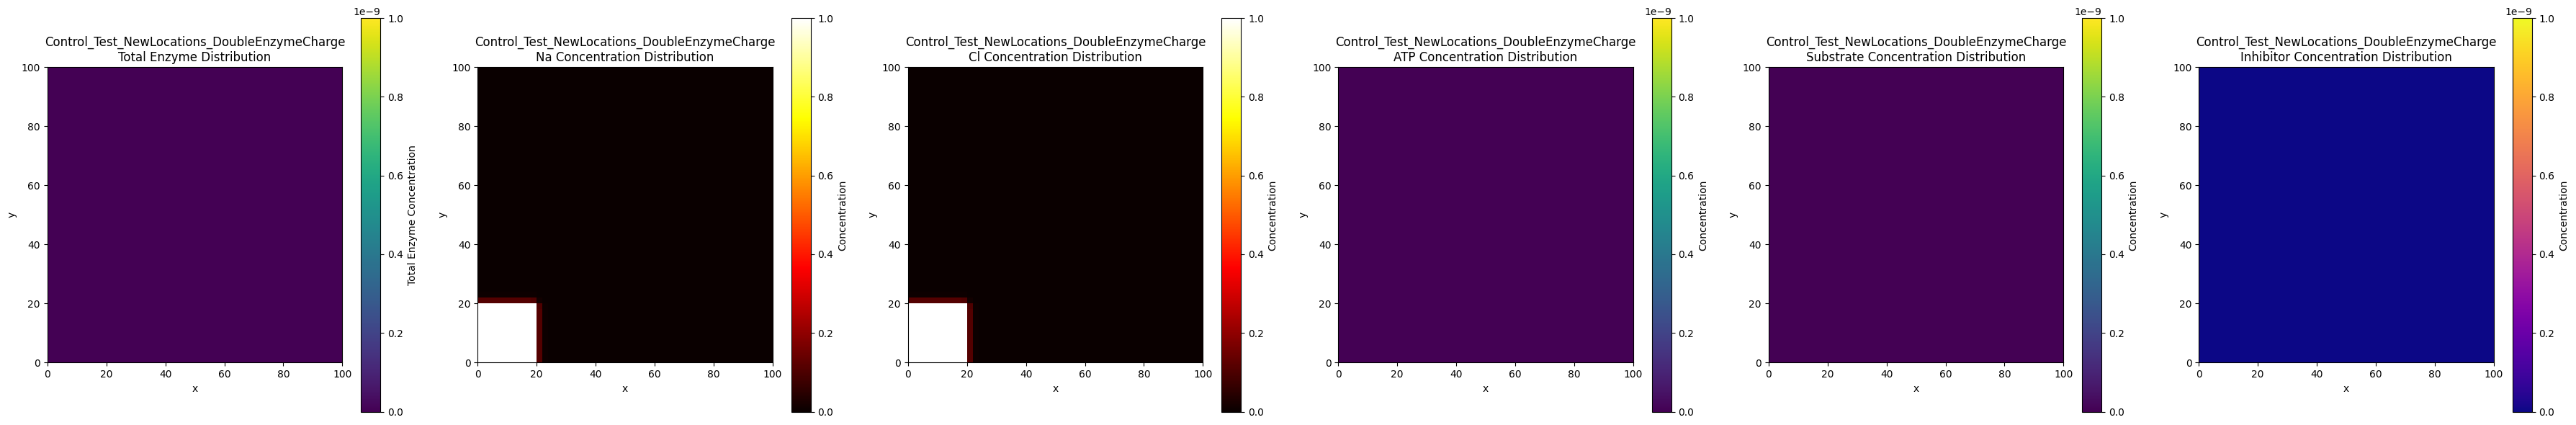

Simulation 'Control_Test_NewLocations_DoubleEnzymeCharge' finished.
Simulation state saved at step 500 to simulation_checkpoints/Control_Test_NewLocations_DoubleEnzymeCharge/Control_Test_NewLocations_DoubleEnzymeCharge_final_state.npz

--- Running simulation condition: Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge ---
Initializing concentrations...
Running simulation 'Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge' from step 0 to 500...
Simulation 'Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge': Time step 100/500 completed. Steps per second: 8.96 Total enzyme: 10.0000
Simulation 'Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge': Time step 200/500 completed. Steps per second: 9.09 Total enzyme: 10.0000
Simulation 'Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge': Time step 300/500 completed. Steps per second: 9.18 Total enzyme: 10.0000
Simulation 'Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge': Time step 400/500 completed. Steps per second: 9.23 Total enzyme: 10.0000
Simula

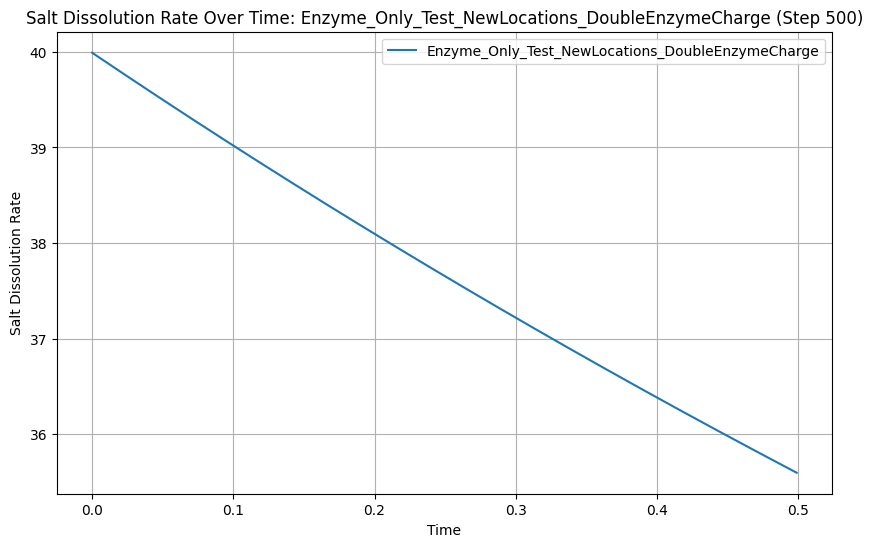

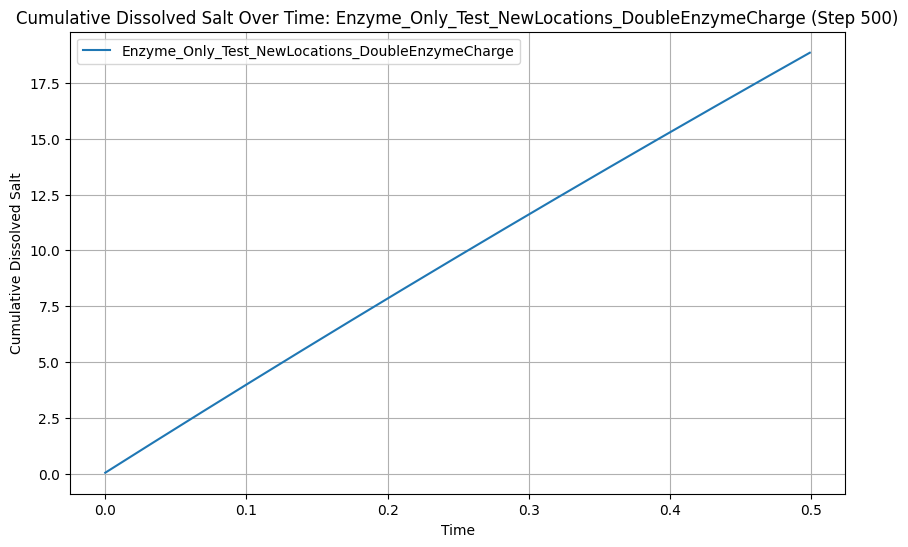

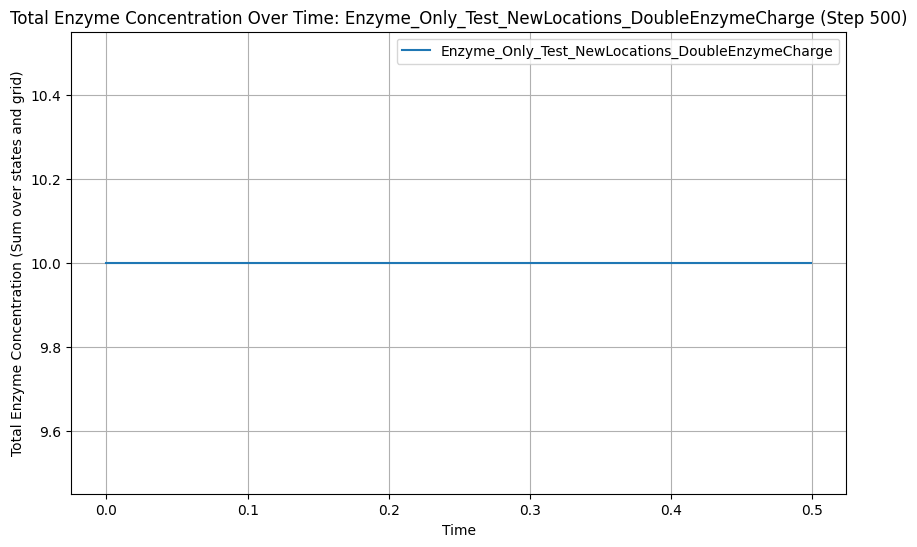

Generating spatial distributions for 'Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge' at step 500...


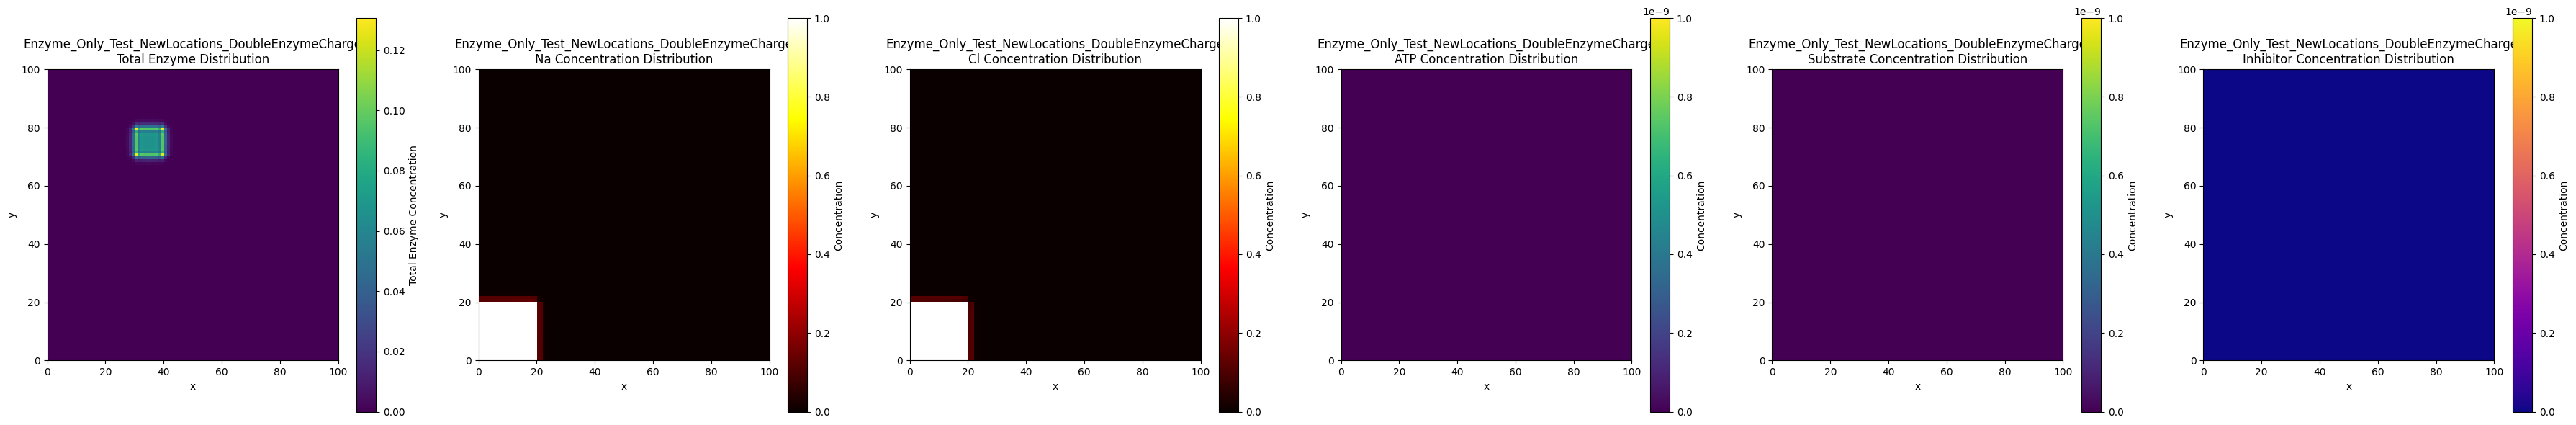

Simulation 'Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge' finished.
Simulation state saved at step 500 to simulation_checkpoints/Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge/Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge_final_state.npz

--- Running simulation condition: Just_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Initializing concentrations...
Running simulation 'Just_ATP_Test_NewLocations_DoubleEnzymeCharge' from step 0 to 500...
Simulation 'Just_ATP_Test_NewLocations_DoubleEnzymeCharge': Time step 100/500 completed. Steps per second: 9.00 Total enzyme: 0.0000
Simulation 'Just_ATP_Test_NewLocations_DoubleEnzymeCharge': Time step 200/500 completed. Steps per second: 9.15 Total enzyme: 0.0000
Simulation 'Just_ATP_Test_NewLocations_DoubleEnzymeCharge': Time step 300/500 completed. Steps per second: 9.15 Total enzyme: 0.0000
Simulation 'Just_ATP_Test_NewLocations_DoubleEnzymeCharge': Time step 400/500 completed. Steps per second: 9.11 Total enzyme: 0.0000
Simulation 'Just

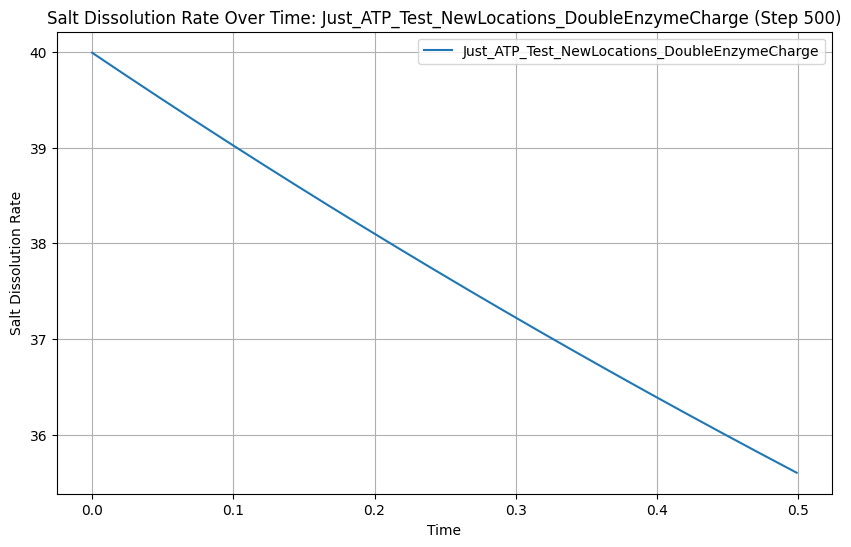

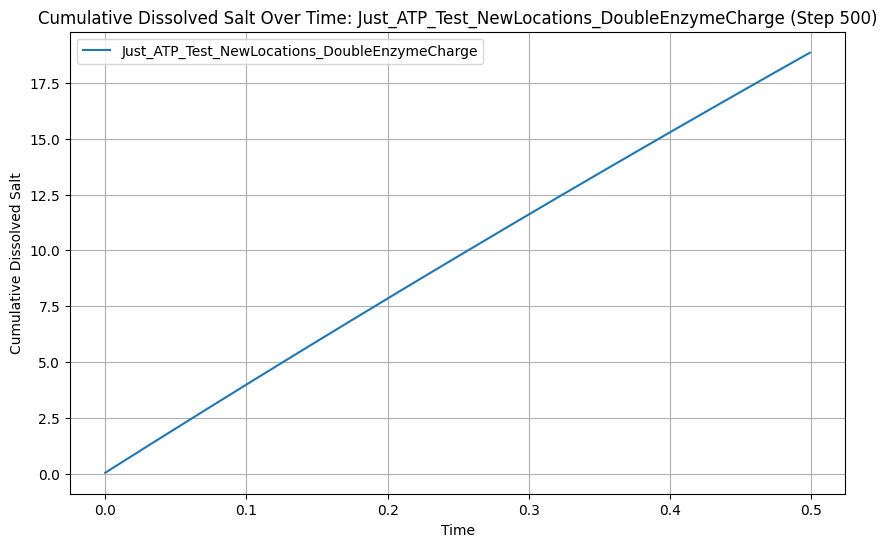

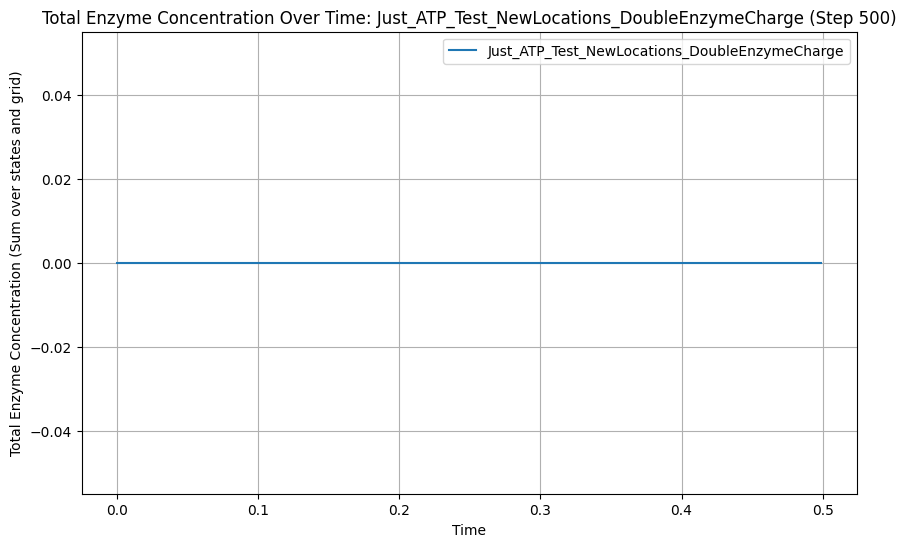

Generating spatial distributions for 'Just_ATP_Test_NewLocations_DoubleEnzymeCharge' at step 500...


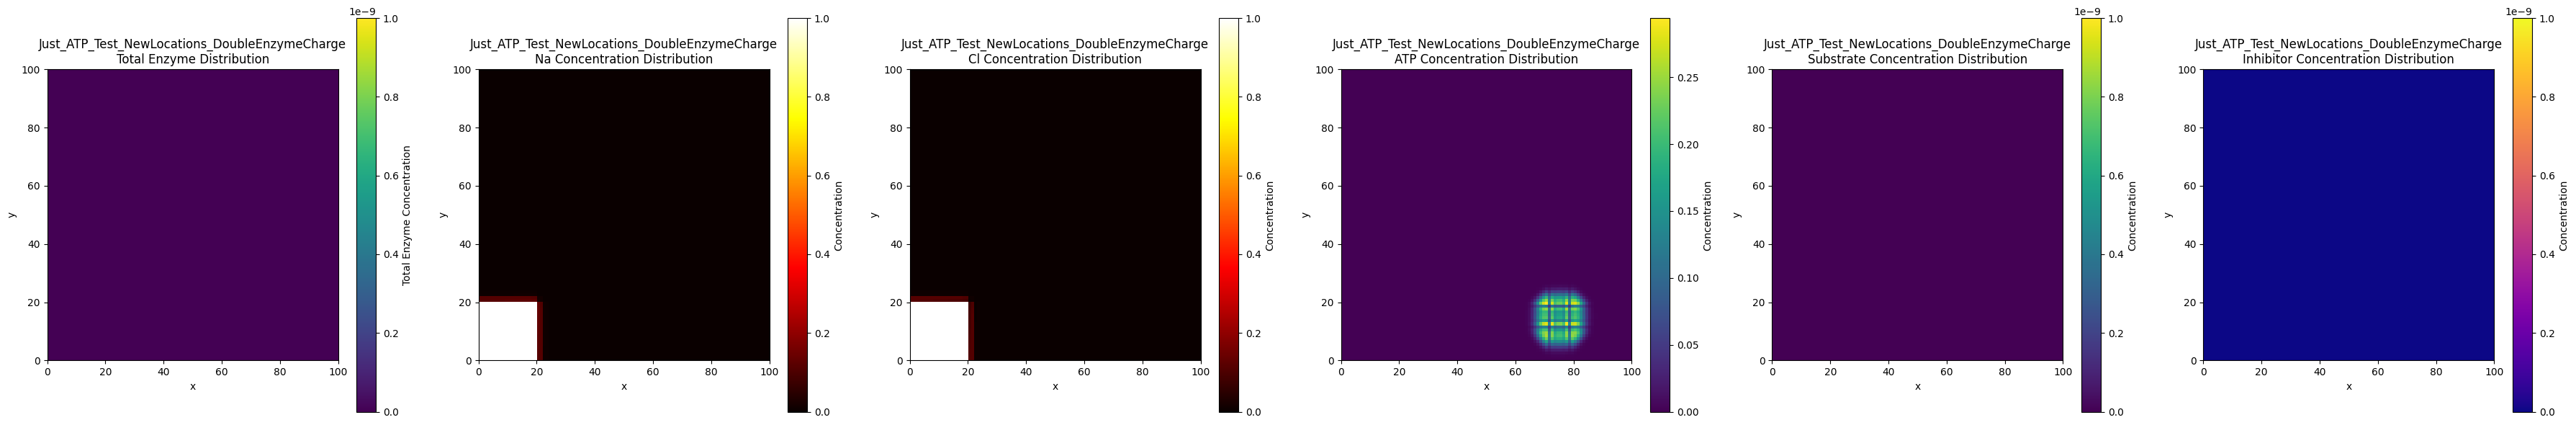

Simulation 'Just_ATP_Test_NewLocations_DoubleEnzymeCharge' finished.
Simulation state saved at step 500 to simulation_checkpoints/Just_ATP_Test_NewLocations_DoubleEnzymeCharge/Just_ATP_Test_NewLocations_DoubleEnzymeCharge_final_state.npz

--- Running simulation condition: Just_Substrate_Test_NewLocations_DoubleEnzymeCharge ---
Initializing concentrations...
Running simulation 'Just_Substrate_Test_NewLocations_DoubleEnzymeCharge' from step 0 to 500...
Simulation 'Just_Substrate_Test_NewLocations_DoubleEnzymeCharge': Time step 100/500 completed. Steps per second: 9.31 Total enzyme: 0.0000
Simulation 'Just_Substrate_Test_NewLocations_DoubleEnzymeCharge': Time step 200/500 completed. Steps per second: 9.19 Total enzyme: 0.0000
Simulation 'Just_Substrate_Test_NewLocations_DoubleEnzymeCharge': Time step 300/500 completed. Steps per second: 9.26 Total enzyme: 0.0000
Simulation 'Just_Substrate_Test_NewLocations_DoubleEnzymeCharge': Time step 400/500 completed. Steps per second: 9.07 Total enzy

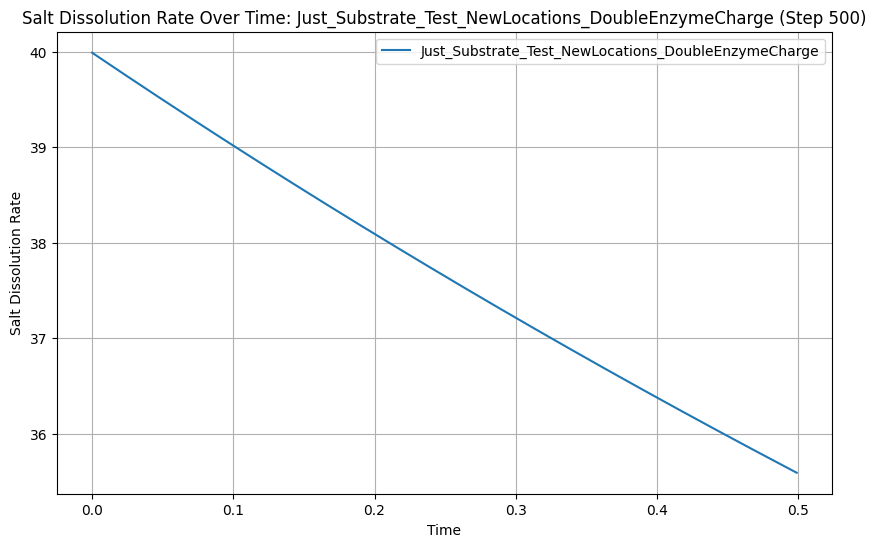

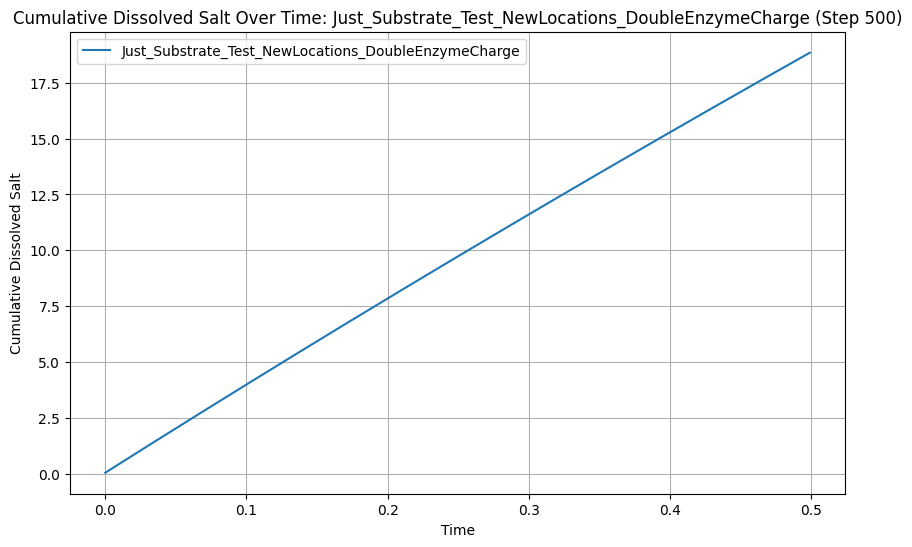

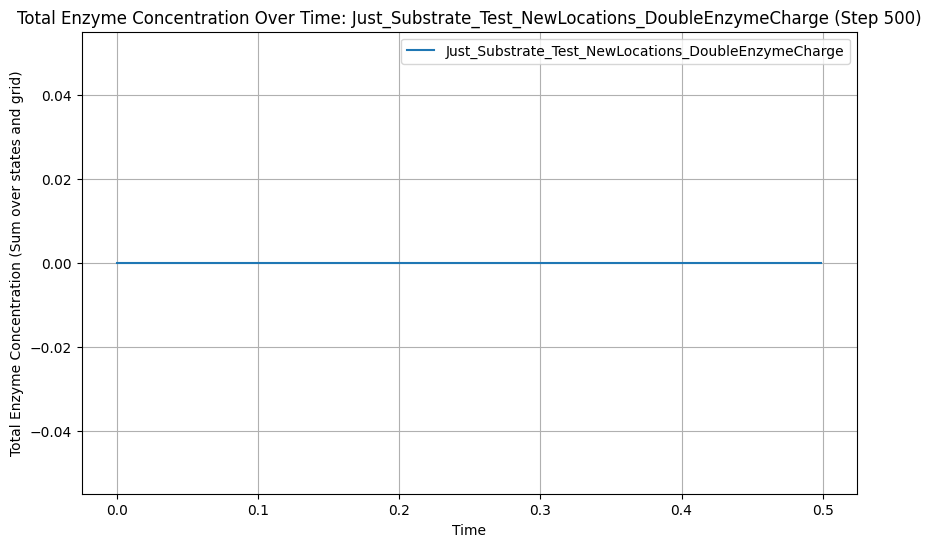

Generating spatial distributions for 'Just_Substrate_Test_NewLocations_DoubleEnzymeCharge' at step 500...


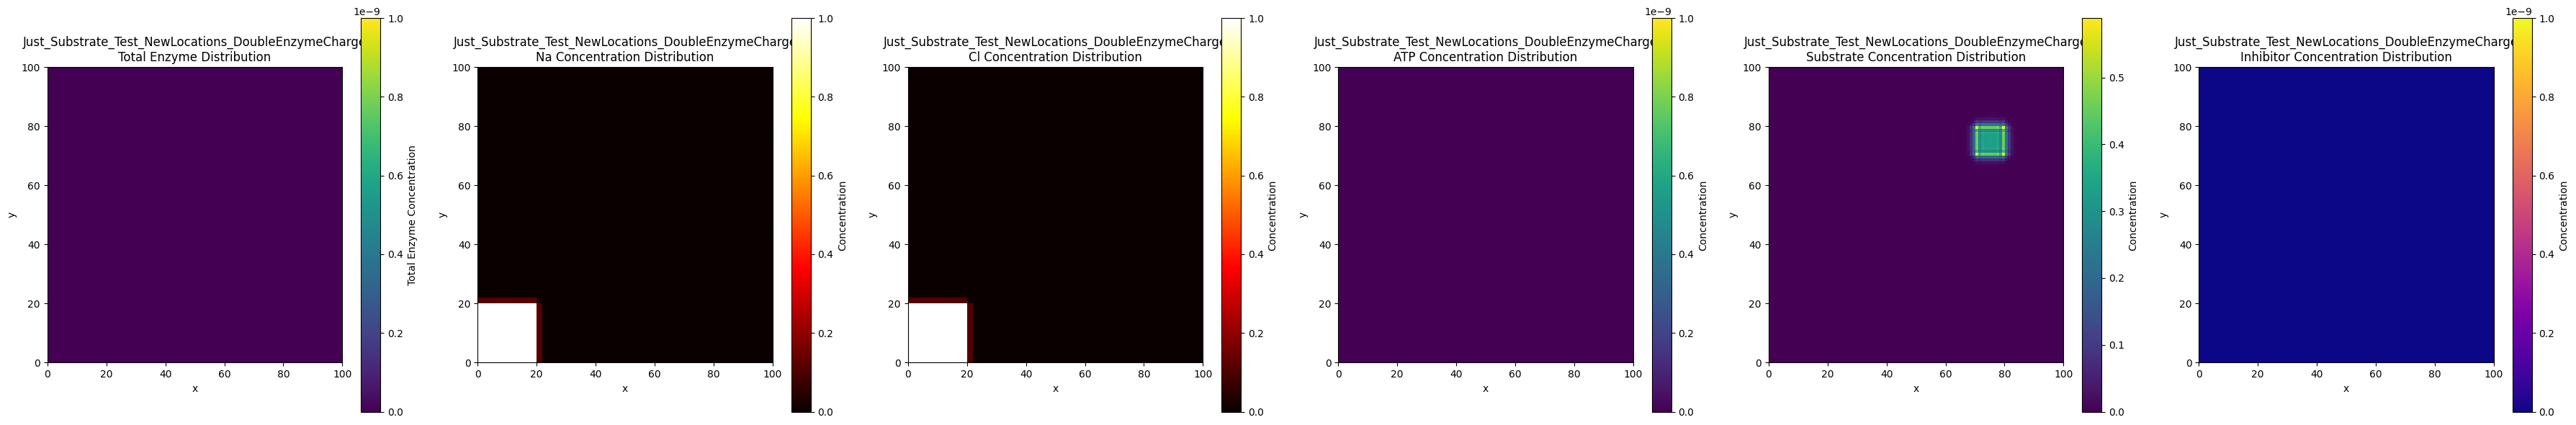

Simulation 'Just_Substrate_Test_NewLocations_DoubleEnzymeCharge' finished.
Simulation state saved at step 500 to simulation_checkpoints/Just_Substrate_Test_NewLocations_DoubleEnzymeCharge/Just_Substrate_Test_NewLocations_DoubleEnzymeCharge_final_state.npz

--- Running simulation condition: Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge ---
Initializing concentrations...
Running simulation 'Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge' from step 0 to 500...
Simulation 'Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge': Time step 100/500 completed. Steps per second: 9.02 Total enzyme: 10.0000
Simulation 'Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge': Time step 200/500 completed. Steps per second: 8.93 Total enzyme: 10.0000
Simulation 'Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge': Time step 300/500 completed. Steps per second: 8.86 Total enzyme: 10.0000
Simulation 'Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge': Time 

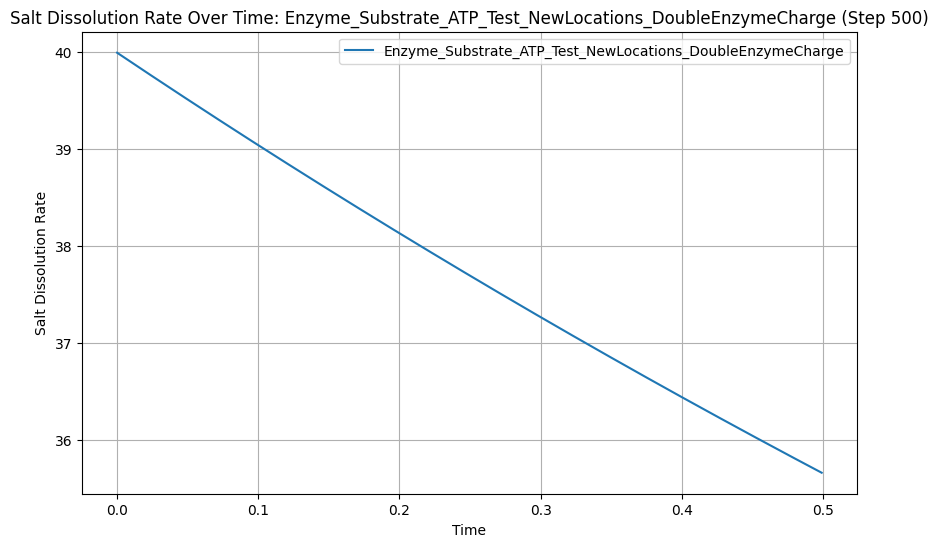

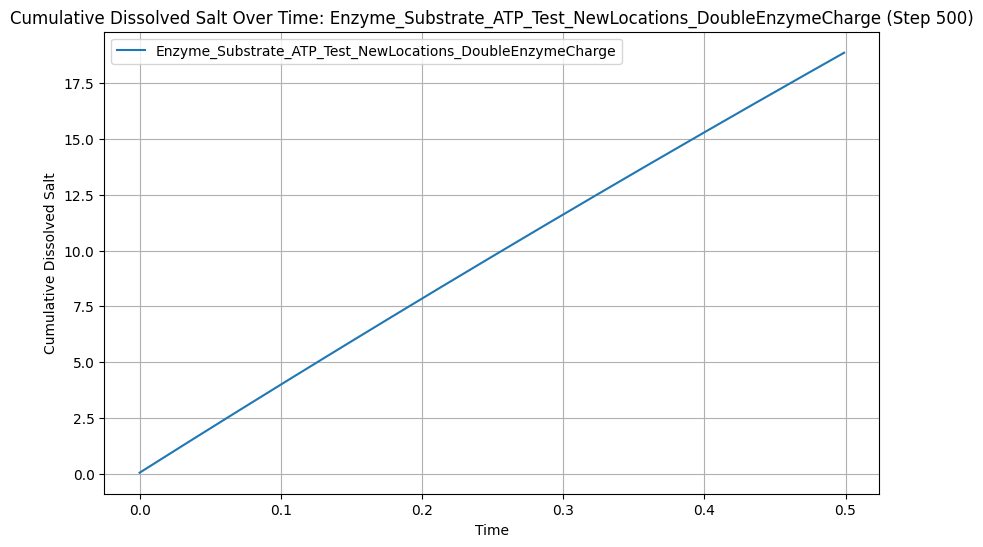

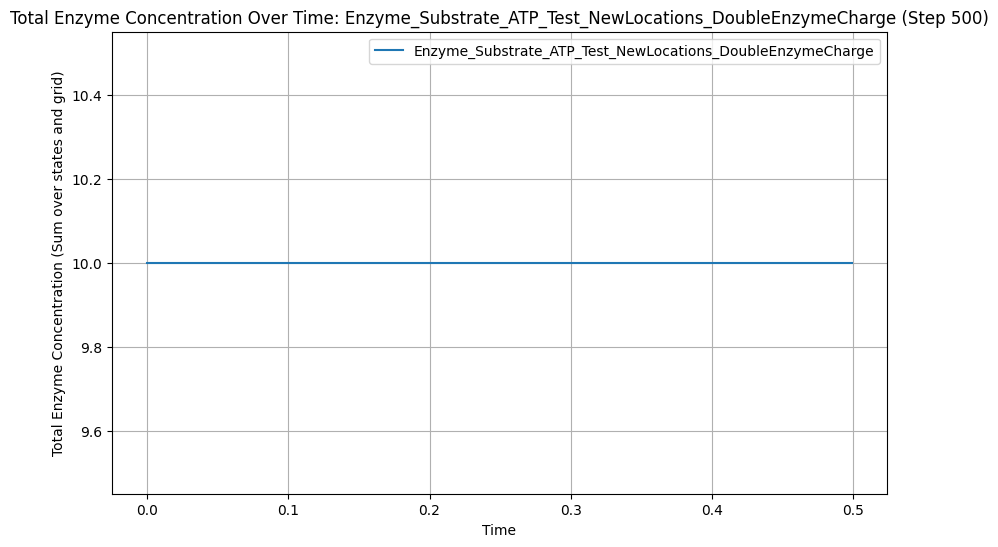

Generating spatial distributions for 'Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge' at step 500...


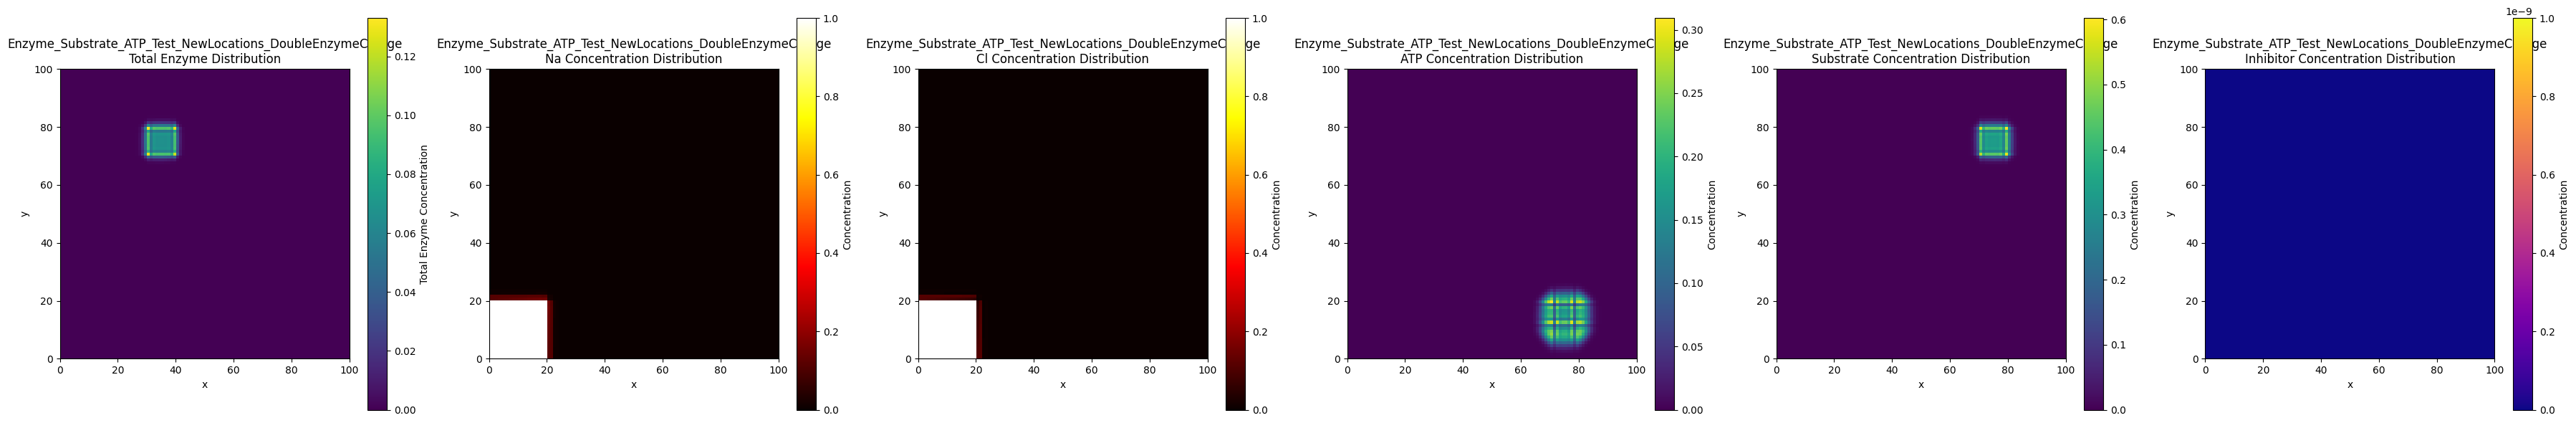

Simulation 'Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge' finished.
Simulation state saved at step 500 to simulation_checkpoints/Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge/Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge_final_state.npz

--- Running simulation condition: Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge ---
Initializing concentrations...
Running simulation 'Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge' from step 0 to 500...
Simulation 'Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge': Time step 100/500 completed. Steps per second: 8.78 Total enzyme: 10.0000
Simulation 'Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge': Time step 200/500 completed. Steps per second: 8.79 Total enzyme: 10.0000
Simulation 'Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge': Time step 300/500 completed. Steps per second: 8.99 Total enzyme: 10.0000
Simulatio

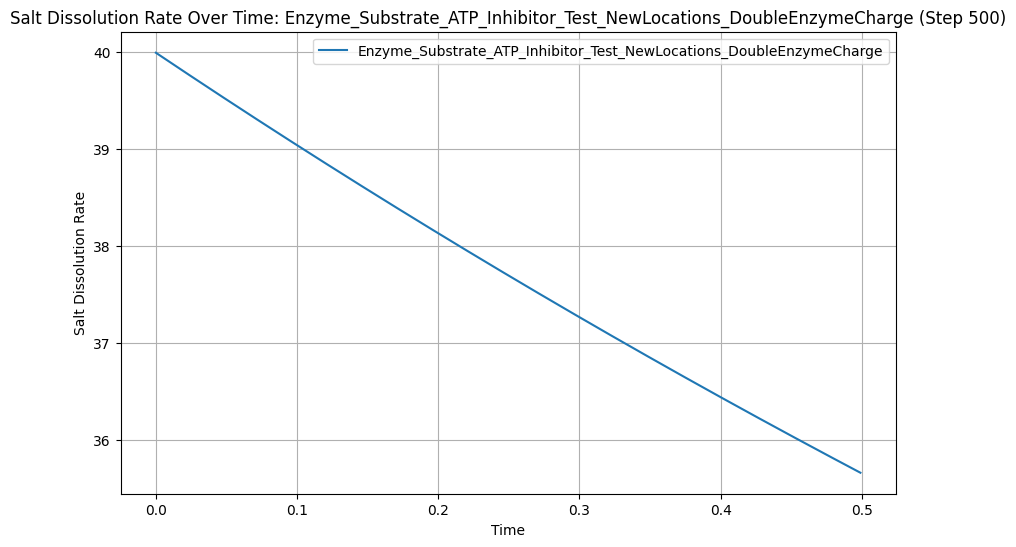

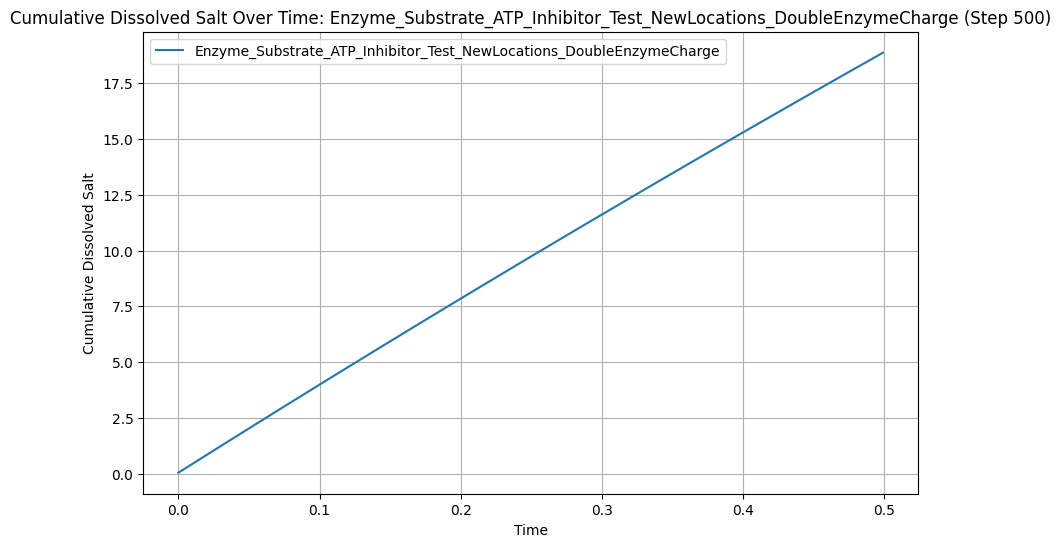

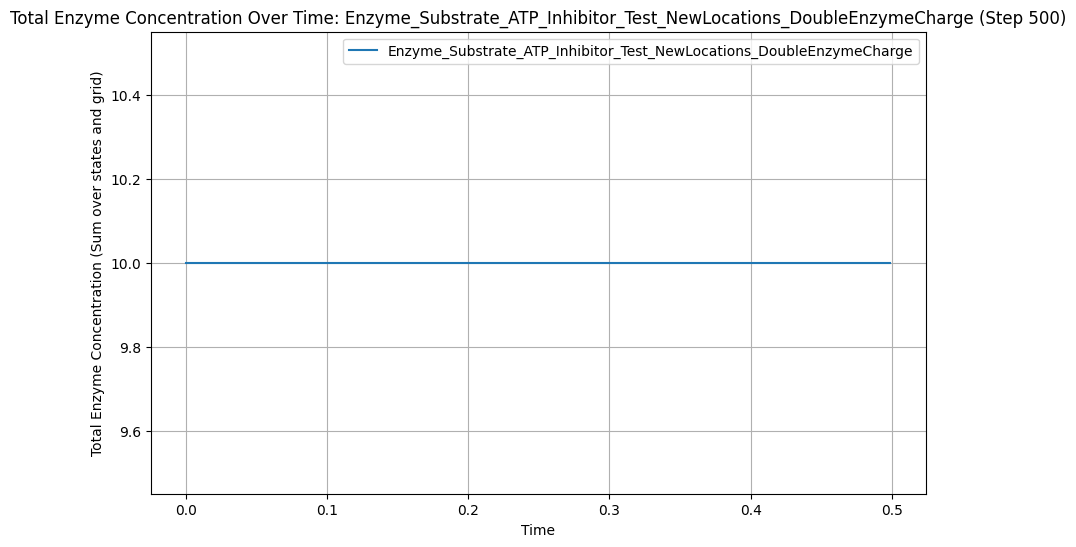

Generating spatial distributions for 'Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge' at step 500...


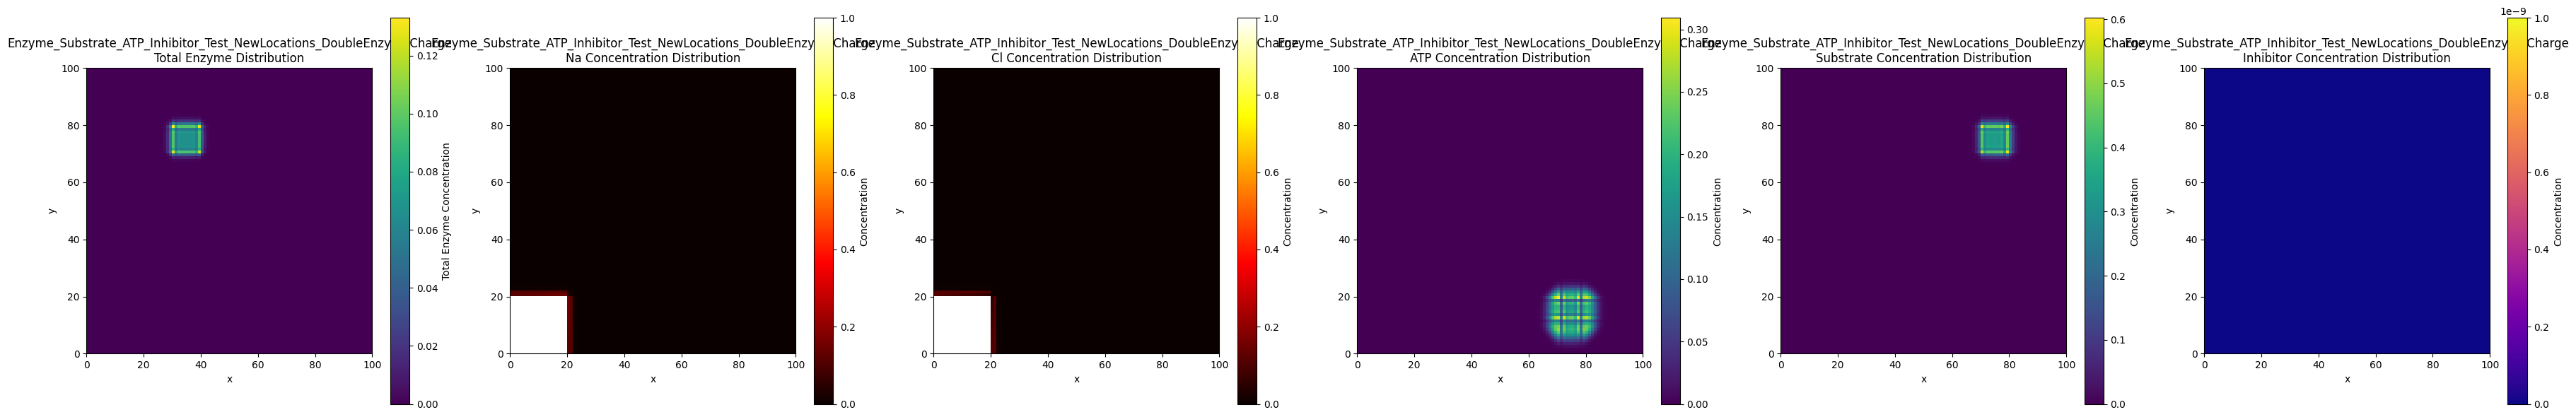

Simulation 'Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge' finished.
Simulation state saved at step 500 to simulation_checkpoints/Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge/Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge_final_state.npz

Short test simulations finished. Review plots above for verification.


In [ ]:
# Cell 4: Run Short Test Simulations (500 steps)

print(f"\nRunning short test simulations ({Nt_test} steps) with updated locations and plotting...")

# Define a flag to control resuming for test runs (usually start from scratch for tests)
resume_test_simulations = False

# 1. Control Simulation (Diffusion + Electrostatics only) - Test Run
initial_concentrations_control_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Control_Test_NewLocations_DoubleEnzymeCharge', # Updated name for clarity
    initial_concentrations=initial_concentrations_control_test,
    Nt=Nt_test,
    dt=dt,
    report_interval=100, # More frequent reporting for short run
    checkpoint_interval=Nt_test + 1, # No checkpointing for short test
    plot_interval=Nt_test, # Plot only at the end of the short test
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy,
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)

# 2. Enzyme Only Simulation - Test Run
initial_concentrations_enzyme_only_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Only_Test_NewLocations_DoubleEnzymeCharge', # Updated name for clarity
    initial_concentrations=initial_concentrations_enzyme_only_test,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location, # Use new enzyme location
    Nt=Nt_test,
    dt=dt,
    report_interval=100,
    checkpoint_interval=Nt_test + 1,
    plot_interval=Nt_test,
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy,
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)

# 3. Just ATP Simulation - Test Run
initial_concentrations_just_ATP_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Just_ATP_Test_NewLocations_DoubleEnzymeCharge', # Updated name for clarity
    initial_concentrations=initial_concentrations_just_ATP_test,
    atp_location=atp_initial_location, # Use new ATP location
    Nt=Nt_test,
    dt=dt,
    report_interval=100,
    checkpoint_interval=Nt_test + 1,
    plot_interval=Nt_test,
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy,
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)


# 4. Just Substrate Simulation (Glucose) - Test Run
initial_concentrations_just_Substrate_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Just_Substrate_Test_NewLocations_DoubleEnzymeCharge', # Updated name for clarity
    initial_concentrations=initial_concentrations_just_Substrate_test,
    substrate_location=substrate_initial_location, # Use new substrate location
    Nt=Nt_test,
    dt=dt,
    report_interval=100,
    checkpoint_interval=Nt_test + 1,
    plot_interval=Nt_test,
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy,
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)


# 5. Enzyme + Substrate + ATP Simulation - Test Run
initial_concentrations_enzyme_substrate_ATP_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Substrate_ATP_Test_NewLocations_DoubleEnzymeCharge', # Updated name for clarity
    initial_concentrations=initial_concentrations_enzyme_substrate_ATP_test,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location, # Use new enzyme location
    atp_location=atp_initial_location, # Pass ATP location specifically
    substrate_location=substrate_initial_location, # Pass Substrate location specifically
    Nt=Nt_test,
    dt=dt,
    report_interval=100,
    checkpoint_interval=Nt_test + 1,
    plot_interval=Nt_test,
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy,
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)

# 6. Enzyme + Substrate + ATP + Inhibitor Simulation (Example) - Test Run
initial_concentrations_enzyme_substrate_ATP_inhibitor_test = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Substrate_ATP_Inhibitor_Test_NewLocations_DoubleEnzymeCharge', # Updated name for clarity
    initial_concentrations=initial_concentrations_enzyme_substrate_ATP_inhibitor_test,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location, # Use new enzyme location
    atp_location=atp_initial_location, # Pass ATP location specifically
    substrate_location=substrate_initial_location, # Pass Substrate location specifically
    inhibitor_location=inhibitor_initial_location, # Use new inhibitor location
    Nt=Nt_test,
    dt=dt,
    report_interval=100,
    checkpoint_interval=Nt_test + 1,
    plot_interval=Nt_test,
    resume_all_simulations=resume_test_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy,
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)


print("\nShort test simulations finished. Review plots above for verification.")

In [ ]:
# Cell 5: Run Full Simulations (5000 steps)

print(f"\nRunning full simulations ({Nt} steps) with updated locations and plotting...")

# Define a master switch for resuming full simulations
resume_full_simulations = False # Set to True to resume from the latest checkpoint for all conditions

# 1. Control Simulation (Diffusion + Electrostatics only) - Full Run
initial_concentrations_control_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Control_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_control_full,
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy,
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)

# 2. Enzyme Only Simulation - Full Run
initial_concentrations_enzyme_only_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Only_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_enzyme_only_full,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location, # Use new enzyme location
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy,
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)

# 3. Just ATP Simulation - Full Run
initial_concentrations_just_ATP_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Just_ATP_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_just_ATP_full,
    atp_location=atp_initial_location, # Use new ATP location
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy,
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)


# 4. Just Substrate Simulation (Glucose) - Full Run
initial_concentrations_just_Substrate_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Just_Substrate_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_just_Substrate_full,
    substrate_location=substrate_initial_location, # Use new substrate location
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy,
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)


# 5. Enzyme + Substrate + ATP Simulation - Full Run
initial_concentrations_enzyme_substrate_ATP_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Substrate_ATP_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_enzyme_substrate_ATP_full,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location, # Use new enzyme location
    atp_location=atp_initial_location, # Pass ATP location specifically
    substrate_location=substrate_initial_location, # Pass Substrate location specifically
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy,
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)

# 6. Enzyme + Substrate + ATP + Inhibitor Simulation (Example) - Full Run
initial_concentrations_enzyme_substrate_ATP_inhibitor_full = create_initial_concentrations(all_species, Ny, Nx)
run_simulation_condition_with_checkpointing(
    'Enzyme_Substrate_ATP_Inhibitor_Full_NewLocations_DoubleEnzymeCharge',
    initial_concentrations=initial_concentrations_enzyme_substrate_ATP_inhibitor_full,
    initial_enzyme_conc=enzyme_initial_concentration,
    enzyme_location=enzyme_initial_location, # Use new enzyme location
    atp_location=atp_initial_location, # Pass ATP location specifically
    substrate_location=substrate_initial_location, # Pass Substrate location specifically
    inhibitor_location=inhibitor_initial_location, # Use new inhibitor location
    Nt=Nt,
    dt=dt,
    report_interval=report_interval,
    checkpoint_interval=checkpoint_interval,
    plot_interval=plot_interval,
    resume_all_simulations=resume_full_simulations,
    # Pass global parameters
    all_species=all_species, enzyme_states_list=enzyme_states_list, charges=charges,
    diffusion_coefficients=diffusion_coefficients, mobilities=mobilities, epsilon=epsilon,
    rate_constants=rate_constants, Nx=Nx, Ny=Ny, dx=dx, dy=dy,
    salt_crystal_x_start=salt_crystal_x_start, salt_crystal_x_end=salt_crystal_x_end,
    salt_crystal_y_start=salt_crystal_y_start, salt_crystal_y_end=salt_crystal_y_end,
    C_salt_sat=C_salt_sat
)

print("\nFull simulations finished.")